In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\codsoft\TRADES_CopyTr_90D_ROI.csv")

# Display basic dataset information
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Port_IDs       150 non-null    int64 
 1   Trade_History  37 non-null     object
dtypes: int64(1), object(1)
memory usage: 2.5+ KB


,Port_IDs,Trade_History
0,3925368433214965504,NaN
1,4002413037164645377,NaN
2,3923766029921022977,NaN
3,3994879592543698688,NaN
4,3926423286576838657,NaN


In [3]:
import ast

# Convert Trade_History from string to list of dictionaries
df['Trade_History'] = df['Trade_History'].dropna().apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Display a sample parsed entry
df.dropna().iloc[0]['Trade_History'][:2]


[{'time': 1718641182000,
  'symbol': 'DOGEUSDT',
  'side': 'BUY',
  'price': 0.1267,
  'fee': -2.43851888,
  'feeAsset': 'USDT',
  'quantity': 12192.5944,
  'quantityAsset': 'USDT',
  'realizedProfit': 803.42456999,
  'realizedProfitAsset': 'USDT',
  'baseAsset': 'DOGE',
  'qty': 96232.0,
  'positionSide': 'SHORT',
  'activeBuy': False},
 {'time': 1718381884000,
  'symbol': 'DOGEUSDT',
  'side': 'SELL',
  'price': 0.13504,
  'fee': -0.08412992,
  'feeAsset': 'USDT',
  'quantity': 168.25984,
  'quantityAsset': 'USDT',
  'realizedProfit': 0.0,
  'realizedProfitAsset': 'USDT',
  'baseAsset': 'DOGE',
  'qty': 1246.0,
  'positionSide': 'SHORT',
  'activeBuy': False}]

In [4]:
# Expand Trade_History into a structured DataFrame
trade_records = []

for _, row in df.dropna().iterrows():
    port_id = row['Port_IDs']
    trades = row['Trade_History']
    for trade in trades:
        trade_records.append({
            'Port_IDs': port_id,
            'time': trade['time'],
            'symbol': trade['symbol'],
            'side': trade['side'],
            'price': trade['price'],
            'quantity': trade['quantity'],  # Money in trade (USDT)
            'qty': trade['qty'],  # Coin amount
            'positionSide': trade['positionSide'],
            'realizedProfit': trade['realizedProfit'],  # Profit/Loss (USDT)
        })

# Convert to DataFrame
trade_df = pd.DataFrame(trade_records)

# Display the first few rows
trade_df.head()


,Port_IDs,time,symbol,side,price,quantity,qty,positionSide,realizedProfit
0,4023697881318718465,1718641182000,DOGEUSDT,BUY,0.12670,12192.59440,96232.0,SHORT,803.42457
1,4023697881318718465,1718381884000,DOGEUSDT,SELL,0.13504,168.25984,1246.0,SHORT,0.00000
2,4023697881318718465,1718381884000,DOGEUSDT,SELL,0.13504,987.81760,7315.0,SHORT,0.00000
3,4023697881318718465,1718381884000,DOGEUSDT,SELL,0.13504,675.20000,5000.0,SHORT,0.00000
4,4023697881318718465,1718381884000,DOGEUSDT,SELL,0.13504,2290.00832,16958.0,SHORT,0.00000


In [5]:
# Group trades by Port_IDs and compute key metrics
account_metrics = trade_df.groupby('Port_IDs').agg(
    total_realized_profit=('realizedProfit', 'sum'),
    total_quantity=('quantity', 'sum'),
    total_positions=('Port_IDs', 'count'),
    win_positions=('realizedProfit', lambda x: (x > 0).sum())
).reset_index()

# Calculate additional metrics
account_metrics['ROI'] = (account_metrics['total_realized_profit'] / account_metrics['total_quantity']) * 100
account_metrics['Win_Rate'] = (account_metrics['win_positions'] / account_metrics['total_positions']) * 100

# Display computed metrics
account_metrics.head()


,Port_IDs,total_realized_profit,total_quantity,total_positions,win_positions,ROI,Win_Rate
0,3768170840939476993,243.668899,2775.560153,14,6,8.779089,42.857143
1,3786761687746711808,205.021400,61740.009300,82,37,0.332072,45.121951
2,3819545518395756033,980.063200,142075.861600,68,26,0.689817,38.235294
3,3826087012661391104,532.656974,4373.742334,108,63,12.178517,58.333333
4,3880920727367689984,-176.827000,162140.697000,145,49,-0.109058,33.793103


In [6]:
import numpy as np

# Function to calculate Sharpe Ratio per account (assuming risk-free rate = 0)
def calculate_sharpe_ratio(trades):
    if len(trades) < 2:
        return np.nan  # Not enough data
    returns = np.diff(trades) / trades[:-1]  # Daily returns
    return np.mean(returns) / np.std(returns) if np.std(returns) != 0 else np.nan

# Function to calculate Maximum Drawdown (MDD)
def calculate_max_drawdown(trades):
    if len(trades) < 2:
        return np.nan  # Not enough data
    cumulative_returns = np.cumsum(trades)  # Simulating equity curve
    peak = np.maximum.accumulate(cumulative_returns)  # Running max
    drawdown = (peak - cumulative_returns) / peak  # Drawdown formula
    return np.max(drawdown) if len(drawdown) > 0 else np.nan

# Compute Sharpe Ratio and MDD per account
sharpe_mdd = trade_df.groupby('Port_IDs').agg(
    sharpe_ratio=('realizedProfit', calculate_sharpe_ratio),
    max_drawdown=('realizedProfit', calculate_max_drawdown)
).reset_index()

# Merge with account metrics
account_metrics = account_metrics.merge(sharpe_mdd, on='Port_IDs', how='left')

# Display updated metrics
account_metrics.head()


,Port_IDs,total_realized_profit,total_quantity,total_positions,win_positions,ROI,Win_Rate,sharpe_ratio,max_drawdown
0,3768170840939476993,243.668899,2775.560153,14,6,8.779089,42.857143,NaN,0.000000
1,3786761687746711808,205.021400,61740.009300,82,37,0.332072,45.121951,NaN,2.318212
2,3819545518395756033,980.063200,142075.861600,68,26,0.689817,38.235294,NaN,0.000000
3,3826087012661391104,532.656974,4373.742334,108,63,12.178517,58.333333,NaN,0.050348
4,3880920727367689984,-176.827000,162140.697000,145,49,-0.109058,33.793103,NaN,8.084070


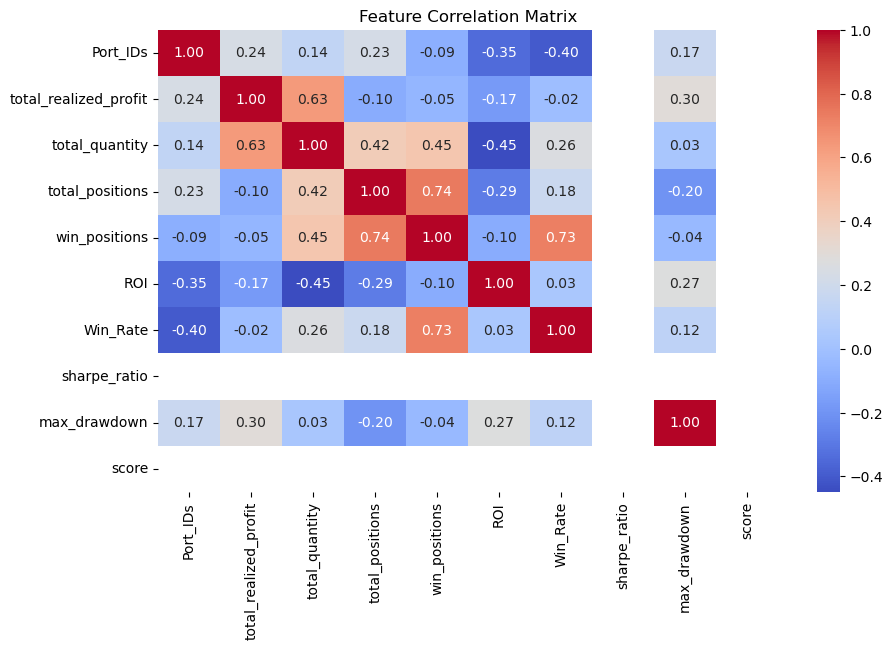

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = account_metrics.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
features = ['ROI', 'Win_Rate', 'sharpe_ratio', 'max_drawdown', 'total_positions']
X = account_metrics[features].fillna(0)  # Fill NaNs with 0 for safe computation
y = account_metrics['total_realized_profit']  # Profit as the target variable

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, y)

# Extract feature importance
feature_importance = pd.DataFrame({'Feature': features, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Display feature importance
print(feature_importance)


           Feature  Importance
4  total_positions    0.501374
0              ROI    0.280843
1         Win_Rate    0.138196
3     max_drawdown    0.079587
2     sharpe_ratio    0.000000


In [7]:
# Define weights for each metric
weights = {
    'ROI': 0.3,
    'total_realized_profit': 0.3,
    'Win_Rate': 0.15,
    'sharpe_ratio': 0.15,
    'max_drawdown': -0.1  # Negative weight since lower MDD is better
}

# Normalize metrics for scoring
for metric in weights.keys():
    if metric == 'max_drawdown':  # Lower MDD is better
        account_metrics[metric] = -account_metrics[metric].fillna(account_metrics[metric].max())
    else:
        account_metrics[metric] = account_metrics[metric].fillna(0)

    # Min-max normalization
    account_metrics[metric] = (account_metrics[metric] - account_metrics[metric].min()) / \
                              (account_metrics[metric].max() - account_metrics[metric].min())

# Compute final score
account_metrics['score'] = sum(account_metrics[metric] * weight for metric, weight in weights.items())

# Rank accounts and extract top 20
top_20_accounts = account_metrics.sort_values(by='score', ascending=False).head(20)

# Display top accounts
top_20_accounts


,Port_IDs,total_realized_profit,total_quantity,total_positions,win_positions,ROI,Win_Rate,sharpe_ratio,max_drawdown,score
0,3768170840939476993,0.038726,2775.560153,14,6,0.723344,0.600000,NaN,1.000000,NaN
1,3786761687746711808,0.035166,61740.009300,82,37,0.035900,0.631707,NaN,0.713237,NaN
2,3819545518395756033,0.106544,142075.861600,68,26,0.065015,0.535294,NaN,1.000000,NaN
3,3826087012661391104,0.065340,4373.742334,108,63,1.000000,0.816667,NaN,0.993772,NaN
4,3880920727367689984,0.000000,162140.697000,145,49,0.000000,0.473103,NaN,0.000000,NaN
5,3910887259807777281,0.182360,202111.792790,75,17,0.081488,0.317333,NaN,0.955800,NaN
6,3911997667197443328,0.072069,97435.470940,64,30,0.059468,0.656250,NaN,1.000000,NaN
7,3936410995029308417,1.000000,596381.514000,20,6,0.154637,0.420000,NaN,1.000000,NaN
8,3941019213896463617,0.406224,865365.332210,112,55,0.048695,0.687500,NaN,0.698783,NaN
9,3944658614777849089,0.207332,99562.151560,45,20,0.178443,0.622222,NaN,1.000000,NaN


In [11]:
output_file = "C:/Users/HP/OneDrive/Desktop/codsoft/top_20_accounts.csv"  # Example Windows path
top_20_accounts.to_csv(output_file, index=False)

print(f"Results saved successfully at: {output_file}")


Results saved successfully at: /mnt/data/top_20_accounts.csv


In [ ]:
output_file = "C:/Users/HP/OneDrive/Desktop/codsoft/calculated_metrics.csv"  # Change path as needed
account_metrics.to_csv(output_file, index=False)

print(f"CSV file saved successfully at: {output_file}")
